In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('train_bio.csv')
df_test = pd.read_csv('test_bio.csv')
df_train.drop(columns='Unnamed: 0',inplace=True)
df_test.drop(columns='Unnamed: 0',inplace=True)

In [3]:
X_train, y_train = df_train.drop(columns=['accuracy']), df_train['accuracy']
X_test, y_test = df_test.drop(columns=['accuracy']), df_test['accuracy']

### 1.1) Try Logistic Regression with all features (full set of categorical features)

In [4]:
# helper function to get cross-validation results
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def show_cv_results(model, x, y, cv=10):
    scores = cross_validate(model, x, y, cv=cv, return_train_score=True)
    print("Mean test score:", scores["test_score"].mean()) # mean test accuracy score
    display(pd.DataFrame(scores))

In [5]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")

show_cv_results(lr, X_train, y_train)

Mean test score: 0.6733043662568885


,fit_time,score_time,test_score,train_score
0,1.508976,0.151135,0.685460,0.858086
1,1.033189,0.146121,0.652819,0.856106
2,0.884436,0.104675,0.649852,0.853135
3,0.856785,0.102536,0.688427,0.854785
4,0.819757,0.097706,0.643917,0.856766
5,0.776747,0.092203,0.688427,0.858416
6,0.796169,0.118853,0.688427,0.851155
7,0.799292,0.095848,0.675595,0.855493
8,0.823633,0.094433,0.666667,0.852194
9,0.855926,0.108011,0.693452,0.855823


In [6]:
show_cv_results(lr, X_test, y_test)

Mean test score: 0.6584003831417624


,fit_time,score_time,test_score,train_score
0,0.368344,0.106246,0.627586,0.870570
1,0.385602,0.108827,0.655172,0.872111
2,0.363761,0.086470,0.620690,0.868259
3,0.364488,0.134605,0.666667,0.873749
4,0.388436,0.079784,0.645833,0.876828
5,0.400478,0.082784,0.611111,0.879138
6,0.364747,0.089461,0.722222,0.864511
7,0.418822,0.105300,0.673611,0.872209
8,0.359607,0.080578,0.673611,0.865281
9,0.426996,0.087554,0.687500,0.862972


In [8]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

### 1.2) Hyperparameter Tuning for Logistic Regression

In [10]:
# https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [11]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")

In [12]:
report_GridSearchCV_results(clf)

Best combination of hyperparams:
 {'C': 0.1, 'penalty': 'l2'} 

Best mean_test_score score:
 0.6780636215910697 

Score by fold for best estimator:
 [0.685459940652819, 0.6765578635014837, 0.6409495548961425, 0.6646884272997032, 0.6468842729970327, 0.7002967359050445, 0.6913946587537092, 0.6845238095238095, 0.6785714285714286, 0.7113095238095238] 



              precision    recall  f1-score   support

           0       0.70      0.89      0.79       959
           1       0.54      0.24      0.34       484

    accuracy                           0.68      1443
   macro avg       0.62      0.57      0.56      1443
weighted avg       0.65      0.68      0.63      1443



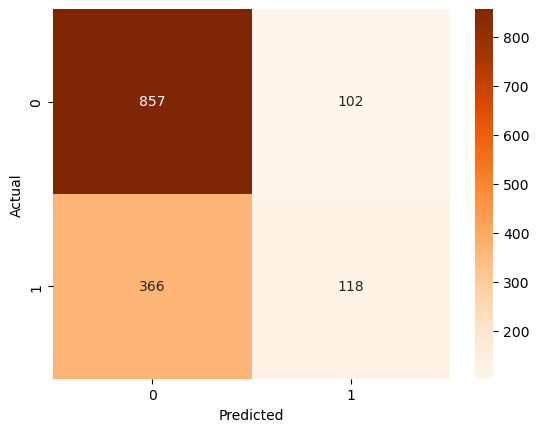

In [13]:
score_model(clf, X_test, y_test)

### 2.1) RandomForest Baseline Model with all features

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)
        
y_train_pred = clf.predict(X_train)
print('Training Accuracy: ', metrics.accuracy_score(y_train, y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print()
y_test_pred = clf.predict(X_test)
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

Training Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2236
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      3367
   macro avg       1.00      1.00      1.00      3367
weighted avg       1.00      1.00      1.00      3367

[[2236    0]
 [   0 1131]]

Test Accuracy:  0.6701316701316701
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       959
           1       0.53      0.15      0.23       484

    accuracy                           0.67      1443
   macro avg       0.61      0.54      0.51      1443
weighted avg       0.63      0.67      0.60      1443

[[894  65]
 [411  73]]


### 2.2) Hyperparameter tuning for RandomForest

#### RandomizedSearchCV

In [15]:
# randomised search

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

distributions = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = distributions, cv = 3, n_jobs = 2)
rf_random.fit(X_train, y_train)

report_GridSearchCV_results(rf_random)

Best combination of hyperparams:
 {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 70, 'bootstrap': False} 

Best mean_test_score score:
 0.6750793250190873 

Score by fold for best estimator:
 [0.6829919857524488, 0.6729055258467023, 0.6693404634581105] 



              precision    recall  f1-score   support

           0       0.68      0.96      0.79       959
           1       0.52      0.10      0.16       484

    accuracy                           0.67      1443
   macro avg       0.60      0.53      0.48      1443
weighted avg       0.62      0.67      0.58      1443



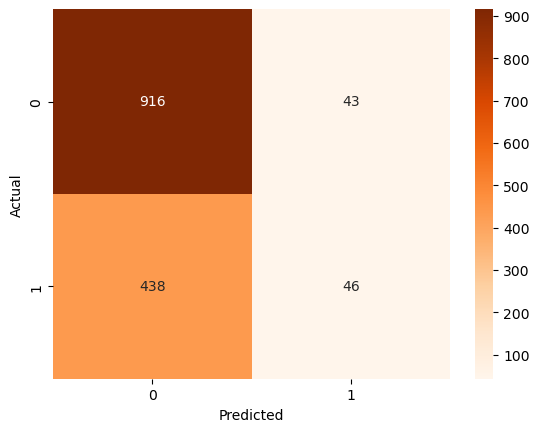

In [16]:
score_model(rf_random, X_test, y_test)

In [17]:
rf = RandomForestClassifier(n_estimators= 1200, min_samples_split=10, min_samples_leaf = 4, max_depth = 60)
rf.fit(X_train,y_train)
sorted_idx = rf.feature_importances_.argsort()
feature_names=X_train.columns

In [18]:
feature_names.__len__()

8022

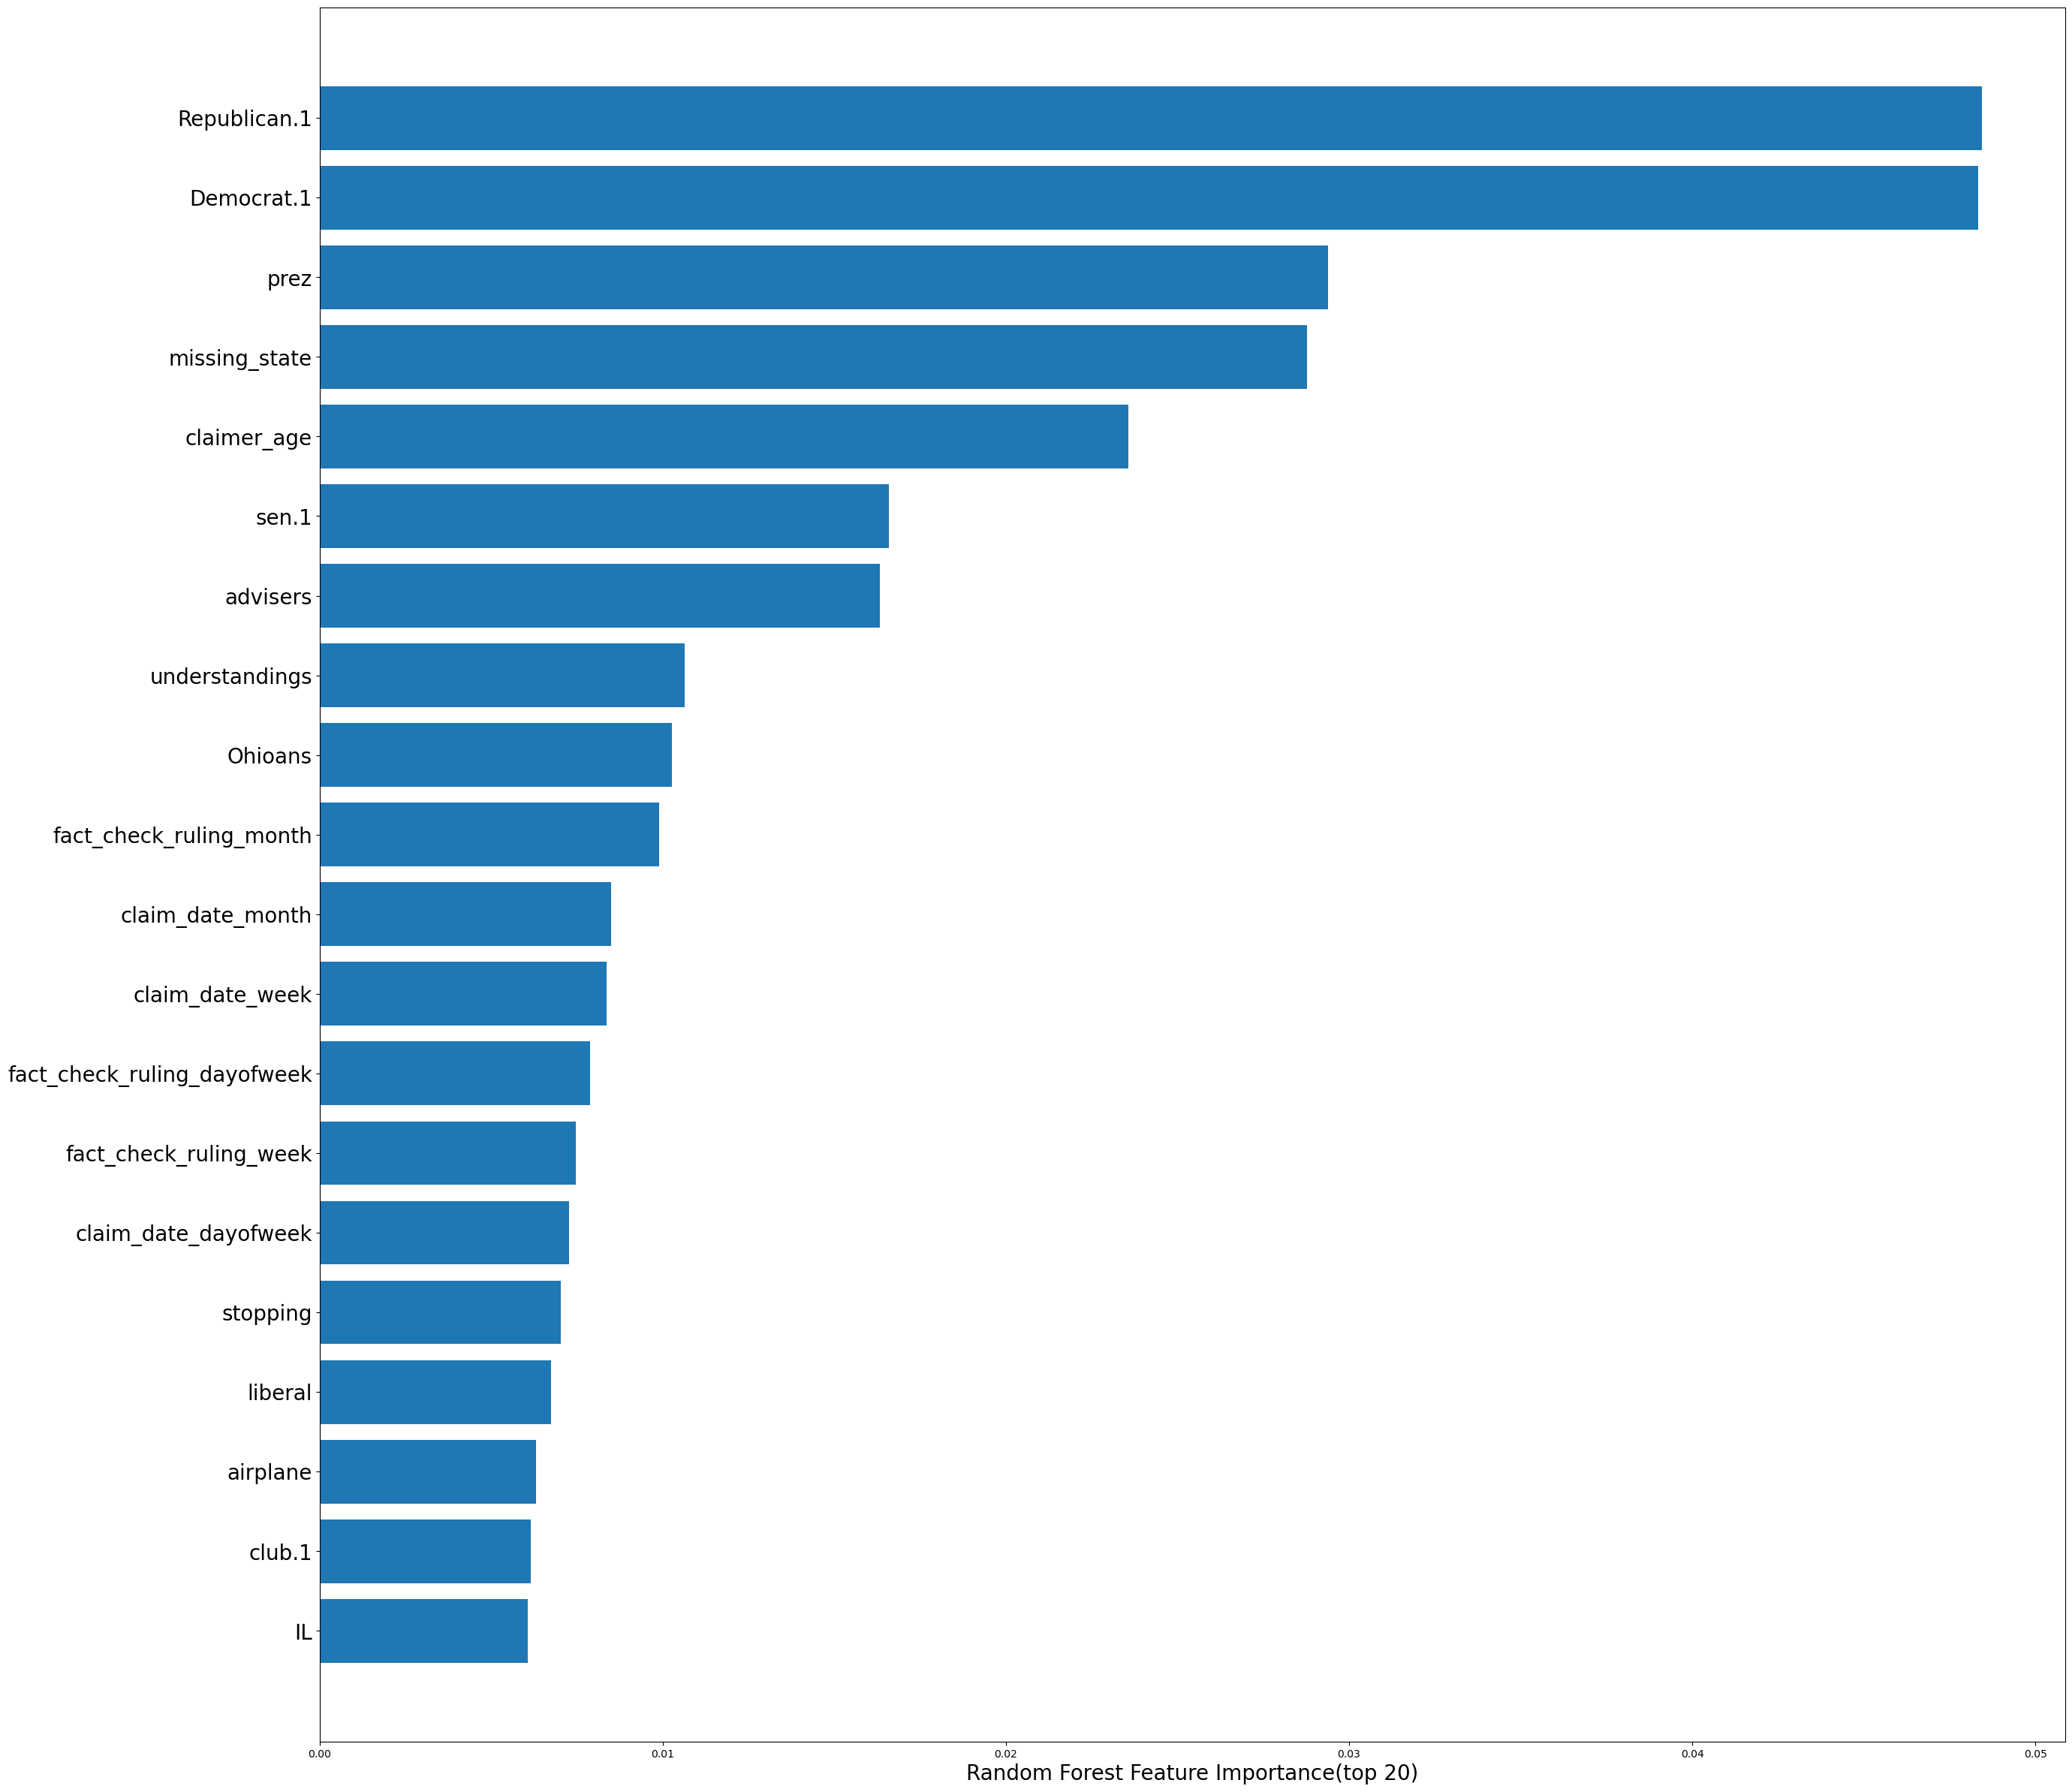

In [19]:
fig, axes = plt.subplots(figsize=(30,30))
plt.barh(feature_names[sorted_idx][feature_names.__len__()-20:],rf.feature_importances_[sorted_idx][feature_names.__len__()-20:])
plt.xlabel("Random Forest Feature Importance(top 20)", fontdict={'size':20})
plt.yticks(font={'size':20})
plt.show()

#### GridSearchCV

In [20]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
grid_rf = {
    "max_depth": [5, 50, 75, 100],
    'min_samples_split': [12, 16, 20],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator = rf,      # model
                   param_grid = grid_rf,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 50, 75, 100],
                         'min_samples_split': [12, 16, 20]},
             scoring='accuracy')

In [21]:
report_GridSearchCV_results(rf_grid)

Best combination of hyperparams:
 {'criterion': 'entropy', 'max_depth': 75, 'min_samples_split': 12} 

Best mean_test_score score:
 0.687547689699025 

Score by fold for best estimator:
 [0.6943620178041543, 0.7002967359050445, 0.6913946587537092, 0.6706231454005934, 0.6795252225519288, 0.685459940652819, 0.7181008902077152, 0.6875, 0.6636904761904762, 0.6845238095238095] 



              precision    recall  f1-score   support

           0       0.68      0.96      0.80       959
           1       0.56      0.11      0.18       484

    accuracy                           0.67      1443
   macro avg       0.62      0.53      0.49      1443
weighted avg       0.64      0.67      0.59      1443



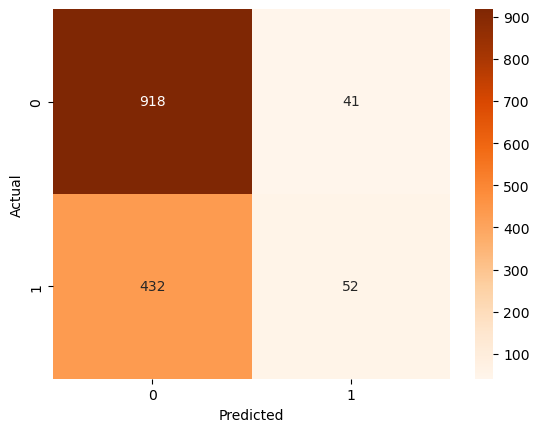

In [22]:
# performance on test set
rf = RandomForestClassifier(random_state=42,max_depth=50,min_samples_split=20)
rf.fit(X_train, y_train)
score_model(rf,X_test,y_test)

### 3) Gradient Boosting

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1,random_state = 42) # max_features=5

gbc.fit(X_train, y_train)

print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.8372438372438372
0.65003465003465


In [24]:
# randomised search for GB

params = {'learning_rate':[0.01,0.05,0.1],
'n_estimators':np.arange(100,500,100)}

search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, random_state=42, cv=3)

gb_rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % gb_rand_search.best_params_)
print('Best Score: %s' % gb_rand_search.best_score_)

Best Hyperparameters: {'n_estimators': 200, 'learning_rate': 0.1}
Best Score: 0.6706269652684194
